# Proximal Gradient Descent with splitting for components 
# Computed tomography (CT) inverse problem with Shepp-Logan Phantom

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#CT Radon transform forward model and denoising functions
from skimage.transform import radon, resize, iradon
from skimage.data import shepp_logan_phantom


#Torch imports
import torch
import torch.nn.functional as F
from torchvision import transforms


# Deep inverse imports
import deepinv as dinv
from deepinv.models import DnCNN, DRUNet

#TV and BM3D imports with tracker
from tqdm import tqdm
from bm3d import bm3d
from utils.torch_denoise_tv_chambolle import *

#local imports (Radon transform, Gaussian noise, FBP, PSNR and PnP-PGD, PnP-FISTA, PnP-ADMM algorithms and all the plotting functions)
from radon import forward_operator_radon, add_noise, fbp
from algorithms import *
from plotting import *



#Reproducible results
torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([transforms.ToTensor()])

# Forward model with Radon transform and noise

In [3]:
#Radon transform (Forward model CT)
#Can have a play around with the number of pixels and angles
n = 30
n_angles = 60
phantom = resize(shepp_logan_phantom(), (n,n))
A = forward_operator_radon(n, n_angles)


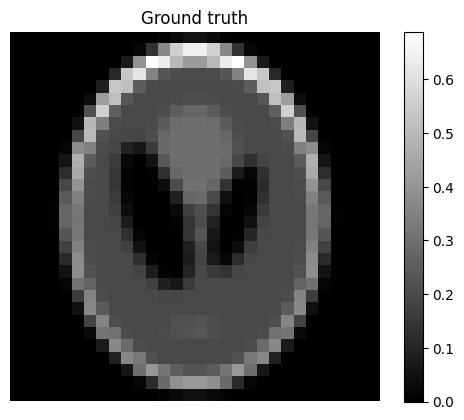

In [5]:
#Plotting the Phantom and corresponding sinogram (noise-free)
plt.imshow(phantom, cmap = 'gray')
plt.title('Ground truth')
plt.axis('off')
plt.colorbar()

C:\Users\as5057\AppData\Local\Temp\ipykernel_3992\4205636105.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = np.reshape(A@phantom.flatten(), (int(np.ceil(n*np.sqrt(2))), n_angles))


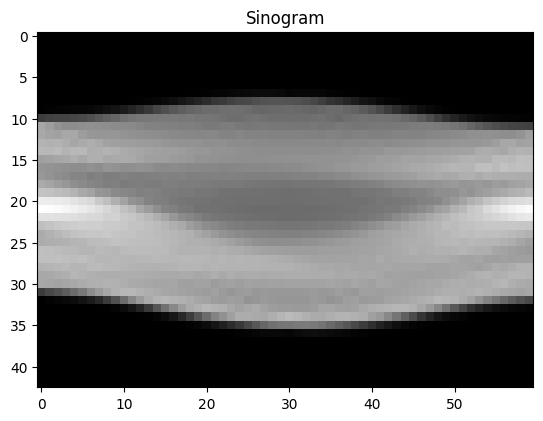

In [29]:
imsize = (n, n)
y = np.reshape(A@phantom.flatten(), (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')
#ground truth
x_gt = torch.from_numpy(phantom).flatten().float()


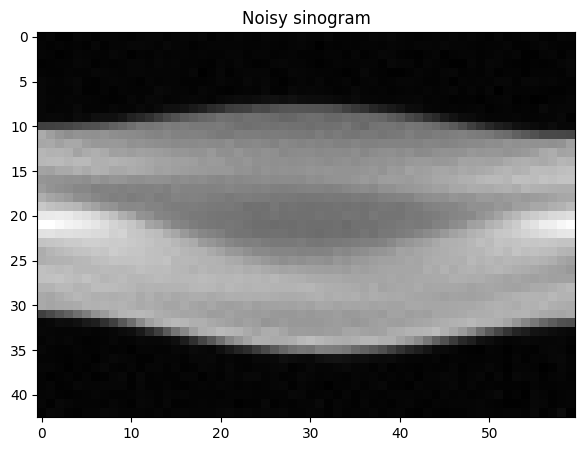

In [11]:
# Add Gaussian and Poisson noise to the sinogram
sigma = 0.05 #Typical noise levels range from 0.01-0.1 (5% of the maximum intensity of the ground truth image)
gauss_y = add_noise(y, noise_type='gaussian', sigma = sigma).float()
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
plt.title("Noisy sinogram")
plt.imshow(gauss_y.numpy(), cmap='gray')


Text(0.5, 1.0, 'Noise-free FBP reconstruction')

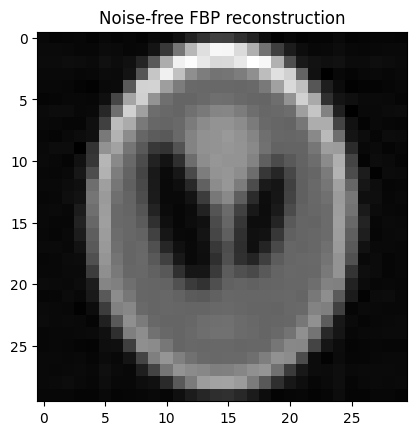

In [12]:
#Noise free FBP
reconstruction_fbp = fbp(y, n_angles)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('Noise-free FBP reconstruction')


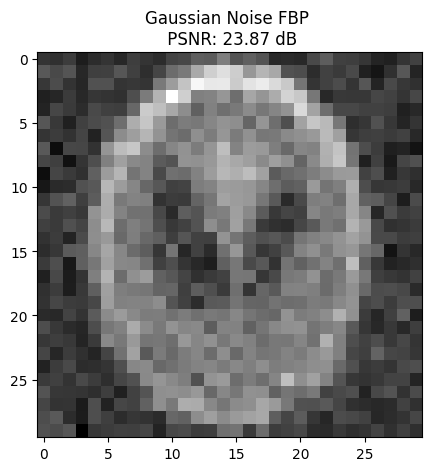

In [13]:
#Noisy reconstruction
gfbp = fbp(gauss_y, n_angles)
gfbp =  gfbp.reshape(n, n) + torch.randn(n,n)*sigma
g_psnr = PSNR(x, gfbp)
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
plt.title(f"Gaussian Noise FBP \n PSNR: {g_psnr:.2f} dB")
plt.imshow(gfbp, cmap='gray')


# Choices for the proximal operator - L1, TV, BM3D

In [90]:
# equivalent function in algorithms.py
def soft_thresh(x, l):
    return torch.sign(x) * F.relu(torch.abs(x) - l)

def apply_denoiser(x, l, sigma = sigma,  method = 'tv'):
        """
        Denoiser options to replace the proximal step
        """
        if method.upper() == "L2" or method == "Tikhonov":
            return x / (1 + l) 
        elif method.upper() == 'L1':
            return soft_thresh(x, l)
        elif method.upper() == 'TV':
            return denoise_tv_chambolle_torch(x, weight = l)
        elif method.upper() == 'BM3D':
            #x = torch.to_numpy(x)
            #print(x.shape)
            x = bm3d(x.reshape(imsize), sigma_psd = sigma*1).flatten()
            return torch.from_numpy(x).float()
        else:
            raise ValueError(f"Unknown denoiser method: {method}")
        

        """
        elif method == 'DnCNN':
            #print('DnCNN')
            x = x.unsqueeze(0).unsqueeze(0)
            x = dncnn(x)
            return x.squeeze(0).squeeze(0)
        elif method == 'DRUNet':
            x = x.reshape(imsize)
            x = x.unsqueeze(0).unsqueeze(0)
            x = drunet(x, sigma = sigma)
            return x.squeeze(0).squeeze(0).flatten().detach()
        """



In [91]:
# splitting PGD algorithm with what the x1 and x2 splittings are - place this in algorithms.py
# in this notebook for display purposes
def pnp_pgd_splitting(A, b, x_truth, method1 = None, method2 = None, reg_parameters = (1e-5, 1e-5), iters = 50, tol = 1e-3, noise_level = 0.05, L = 0):
    """
    PnP proximal gradient descent algorithm (PnP-PGD) with the splitting of x into x1 and x2

    Parameters:
    A: Forward operator
    b: Noisy sinogram
    x_truth: Ground truth image
    method: Denoiser method to use (e.g., 'l1', 'tv', 'bm3d')
    reg_parameters: Regularisation parameters for the two regularisation methods
    iters: Number of iterations for the algorithm
    tol: Tolerance for the termination criterion
    noise_level: Noise level for the denoiser
    L: Lipschitz constant for the gradient of the data fidelity term (if 0, it will be estimated)

    Returns:
    x: Reconstructed image
    psnrs: List of PSNR values for performance comparison
    """

    # dimensions parameters for the image
    n = int(np.sqrt(A.shape[1]))
    imsize = (n,n)
    psnrs = [] #list of PSNR values for perforamance comparison

    #Stepsize estimation via the power method
    #L = torch.norm(A) ** 2  # Lipschitz constant
    if L == 0:
        L = power_method(A.T @ A)
    t = 1 / L # Initial stepsize
    x = fbp(b, n_angles).flatten()  # Initial guess from FBP
    b = b.flatten()


    # Initial estimiate
    #can play around with this splitting
    x1 = 0.3*x.clone()  # Splitting x into x1 and x2
    x2 = x - x1 

    #f = lambda x: 0.5 * torch.norm(A @ x - b) ** 2
    #grad_f =lambda x: A.T @ (A @ x - b)
    for i in tqdm(range(iters), desc = str(method1) + '+' + str(method2) + '-PnP PGD iterations'):
        x_curr = x1 + x2  # Reconstruct x from x1 and x2
        #gradient descent step
        current_grad = A.T @ (A @ x_curr - b)
        

        #z intermediate variable - gradient step of PGD
        z1 = x1 - (t * current_grad)
        z2 = x2 - (t * current_grad)

        #denoising step (proximal step)
        x1_new = apply_denoiser(z1, reg_parameters[0], imsize,  method = method1)#, sigma = noise_level)
        x2_new = apply_denoiser(z2, reg_parameters[1], imsize,  method = method2)#, sigma = noise_level)
     
        #Iterates updated
        x1, x2 = x1_new, x2_new  # Update x1 and x2
        x = x1 + x2 
        components = torch.cat((x1, x2), dim=0)


        psnr = PSNR(x_truth, x).detach()
        psnrs.append(psnr)
        if torch.norm(current_grad) <= tol:  # Termination criterion
            print('Iteration {}: gradient norm {:.4e} is less than tolerance {}\n'.format(i, torch.norm(current_grad), tol))
            break

    print(f"PnP-{method1}+{method2} Final PSNR: {psnr:.2f} dB")

    return x, components, psnrs


In [92]:
#Examples with (TV, L1) and (L2, L1)
#Play around with the regularisation parameters
x_tv_l1, x_components, x_psnrs = pnp_pgd_splitting(A, gauss_y, x_truth = x_gt, method1 = 'tv', method2 = 'L1', reg_parameters = (1e-5, 1e-5), iters = 100, tol = 1e-3, noise_level = sigma)
x_l2_l1, x_components_l2, x_psnrs_l2 = pnp_pgd_splitting(A, gauss_y, x_truth = x_gt, method1 = 'l2', method2 = 'L1', reg_parameters = (1e-5, 1e-5), iters = 100, tol = 1e-3, noise_level = sigma)

tv+L1-PnP PGD iterations: 100%|██████████| 100/100 [00:00<00:00, 567.70it/s]


PnP-tv+L1 Final PSNR: 35.58 dB


l2+L1-PnP PGD iterations: 100%|██████████| 100/100 [00:00<00:00, 797.12it/s]

PnP-l2+L1 Final PSNR: 35.40 dB


In [96]:
# plot final reconstruction, components and compare to ground truth and noisy FBP
#plotting function
def plot_results(x, x_truth, x_components, imsize, psnrs, methods = ('TV', 'L1')):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title(f"PnP-{methods} Reconstruction \n PSNR: {psnrs[-1]:.2f} dB")
    plt.imshow(x.reshape(imsize), cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.title(f"Component 1 ({methods[0]})")
    plt.imshow(x_components[:n*n].reshape(imsize), cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.title(f"Component 2 ({methods[1]})")
    plt.imshow(x_components[n*n:].reshape(imsize), cmap='gray', vmin=0, vmax=1)
    plt.colorbar()
    plt.tight_layout()

def plot_psnrs(psnrs, methods = ('TV', 'L1')):
    plt.figure(figsize=(10, 5))
    plt.plot(psnrs, label=f'PnP-{methods[0]}+{methods[1]} PSNR')
    plt.xlabel('Iteration')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR over iterations')
    plt.legend()
    plt.grid()
    plt.show()

def comparison_psnrs(psnrs_list, methods_list):
    plt.figure(figsize=(10, 5))
    for psnrs, methods in zip(psnrs_list, methods_list):
        plt.plot(psnrs, label=f'PnP-{methods[0]}+{methods[1]} PSNR')
    plt.xlabel('Iteration')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR over iterations for different methods')
    plt.legend()
    plt.grid()
    plt.show()

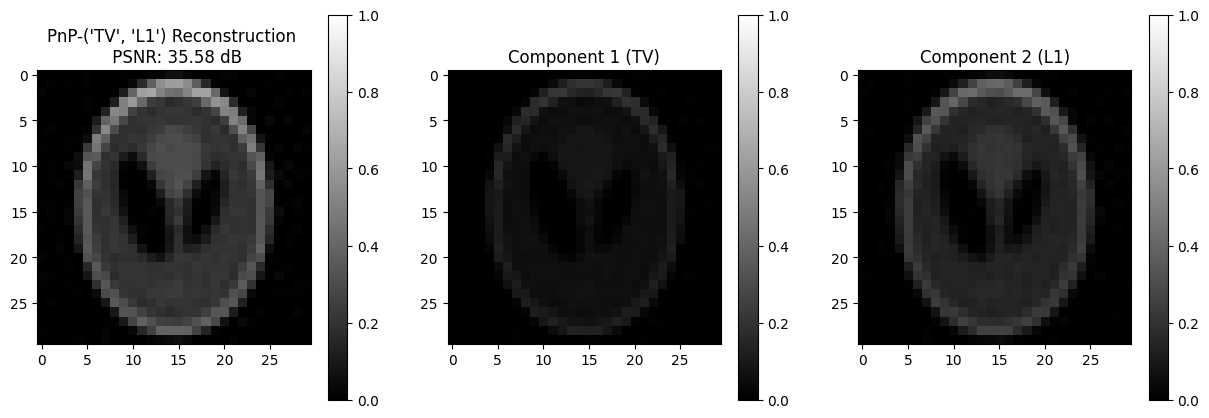

In [86]:
plot_results(x_tv_l1, x_gt, x_components, imsize, x_psnrs, methods = ('TV', 'L1'))

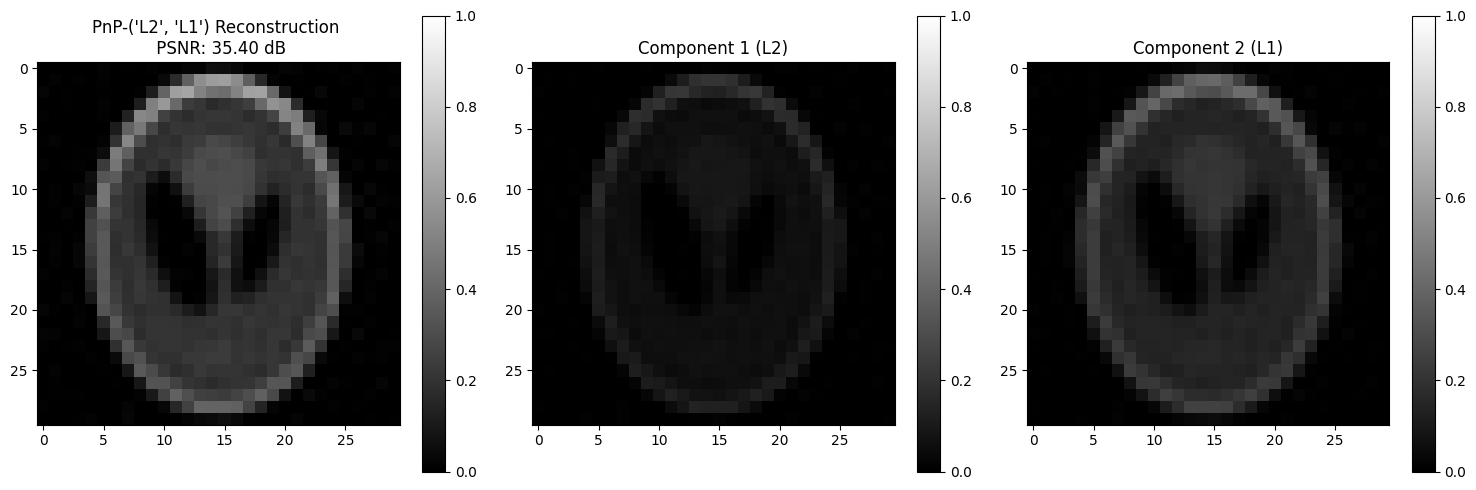

In [100]:
plot_results(x_l2_l1, x_gt, x_components_l2, imsize, x_psnrs_l2, methods = ('L2', 'L1'))

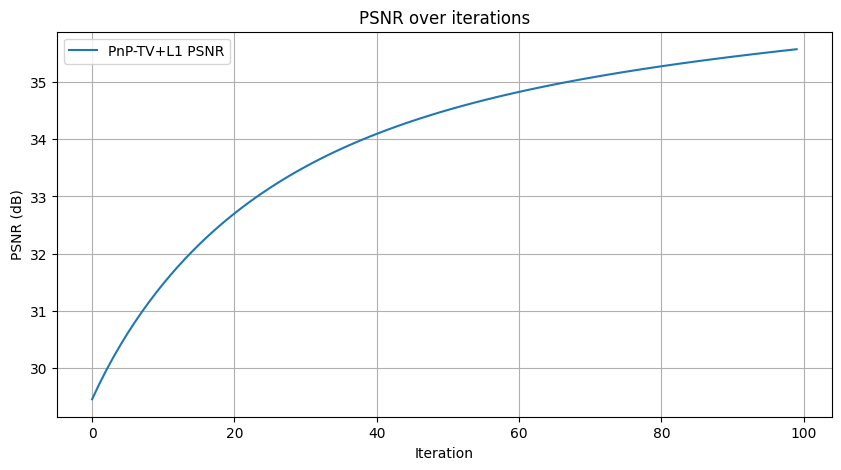

In [98]:
plot_psnrs(x_psnrs, methods = ('TV', 'L1'))

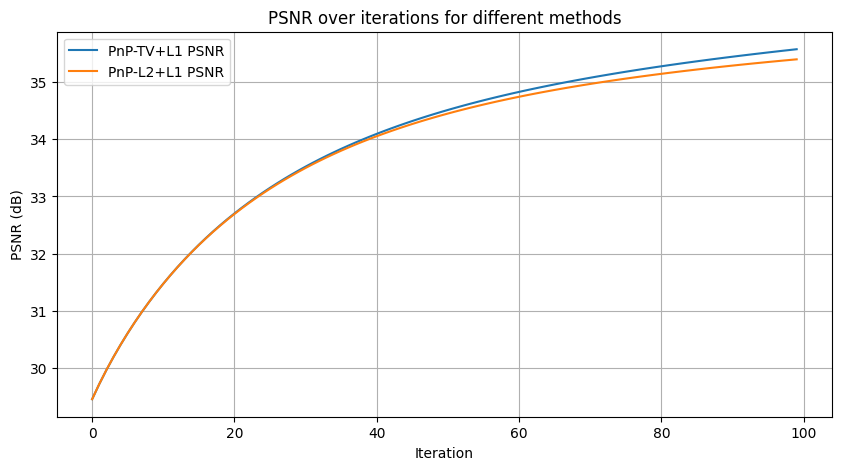

In [99]:
comparison_psnrs([x_psnrs, x_psnrs_l2], methods_list = [('TV', 'L1'), ('L2', 'L1')])